Opinion: Softmax Regression is just a simple linear models with not much use in practice but i heard that the softmax function is used in LLMs. might give it some more thoughts down the road


In [65]:

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

torch.manual_seed(50)

In [66]:
transform = transforms.Compose([
    transforms.ToTensor(),                      # Converts [0,255] → [0,1]
    transforms.Normalize((0.5,), (0.5,))        # Mean=0.5, Std=0.5 → [-1,1]
])
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=transform,
    download=True
)



In [67]:
train_loader = DataLoader(
    train_dataset,
    batch_size=10,   # Number of samples per batch
    shuffle=True,    # Shuffle training data
    num_workers=2    # Parallel data loading threads
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)


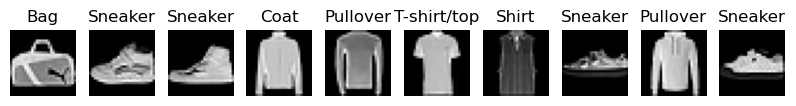

In [68]:
import matplotlib.pyplot as plt
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# 5. Get one batch
images, labels = next(iter(train_loader))

# 6. Plot the batch
plt.figure(figsize=(10, 3))
for i in range(len(images)):
    img = images[i].squeeze()           # remove channel dim
    img = img * 0.5 + 0.5               # unnormalize from [-1,1] → [0,1]
    plt.subplot(1, len(images), i+1)
    plt.imshow(img, cmap="gray")
    plt.title(classes[labels[i]])
    plt.axis("off")

plt.show()

In [69]:
def initialize_weight(input_dim,output_dim):
    W = torch.rand(size=(input_dim,output_dim,))*torch.randint(-2,2,size=(input_dim,output_dim,))*0.01
    b = torch.rand(size = (output_dim,)) * torch.randint(-2,2,size=(output_dim,))*0.01
    W.requires_grad=True
    b.requires_grad=True
    return W,b

In [70]:
class SoftmaxRegression:
    def __init__(self,input_dim,output_dim,learning_rate,batch_size,train_dataset,test_dataset,epoch = 10):
        self.epoch = epoch
        self.lr = learning_rate
        self.batch = batch_size

        self.inD = input_dim
        self.outD = output_dim
        self.W, self.b = initialize_weight(input_dim,output_dim)

        self.train_dataset=train_dataset
        self.test_dataset=test_dataset
        self.optimizer = torch.optim.SGD([self.W,self.b],self.lr)
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch,   # Number of samples per batch
            shuffle=True,    # Shuffle training data
            num_workers=2    # Parallel data loading threads
        )

        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=64,
            shuffle=False
        )
    def softmax(self,X):
        X_exp = torch.exp(X)
        partition = X_exp.sum(dim=1,keepdim=True)
        return X_exp/partition
    def cross_entropy_loss(self,y_hat,y):
        return -torch.log(y_hat[list(range(len(y_hat))),y]).mean()
    def forward(self,X):
        return self.softmax(self.b+X@self.W)
    def fit(self):
        for epoch in range(self.epoch):
            total_loss=0
            for X,y in self.train_loader:
                self.optimizer.zero_grad()
                X = X.view(X.size(0),-1)
                y_hat = self.forward(X)
                loss = F.cross_entropy(y_hat,y)
                loss.backward()
                self.optimizer.step()
            total_loss += loss.item()
            print(f"Epoch {epoch+1}/{self.epoch}, Loss: {total_loss/len(self.train_loader):.4f}")   
    def evaluate(self):
        self.W.requires_grad = False
        self.b.requires_grad = False
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in self.test_loader:
                X = X.view(X.size(0), -1)
                y_hat = self.forward(X)
                predicted = torch.argmax(y_hat, dim=1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        self.W.requires_grad = True
        self.b.requires_grad = True    

In [71]:
SR = SoftmaxRegression(784,10,0.01,128,train_dataset,test_dataset)

In [72]:
SR.fit()

Epoch 1/10, Loss: 0.0040


KeyboardInterrupt: 

In [ ]:
SR.evaluate()

Test Accuracy: 82.86%
